In [53]:
!python --version

Python 3.8.6


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import pathlib
import random
import datetime
import functools
import pickle

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [3]:
root_dir = pathlib.WindowsPath(".")
root_temp_dir = pathlib.Path(root_dir)
code_dir = pathlib.Path(root_dir)
temp_dir = pathlib.Path(root_temp_dir, "_Temporary")
temp_dir.mkdir(exist_ok = True, parents = True)

In [4]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bahug\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
import re

In [7]:
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.3.0


In [8]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [9]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [10]:
df = pd.read_csv('../trainingandtestdata/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [12]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [13]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]

In [14]:
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [15]:
val_count = df.sentiment.value_counts()

Text(0.5, 1.0, 'Sentiment Data Distribution')

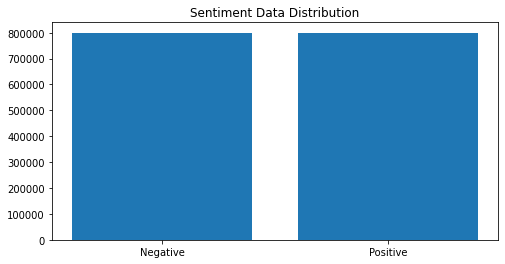

In [16]:
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [17]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
1252417,Positive,"We need our Big Bookers, but the newer ones ar..."
619755,Negative,Feels really sick now
1037345,Positive,so HAPPY for you!!
283962,Negative,BBQ tonight! yay! drinking Pimms! yay! - can a...
984370,Positive,Goodmorning 2 all aout there.....coffe &amp; s...
974495,Positive,"Sorry that wasn't an earthquake, that was just..."
387178,Negative,Have a graduation party today for Sarah's neic...
518956,Negative,I have a ladder in my tights Like huuuuge!
821001,Positive,"@dda No, I kept the really loud one."
871063,Positive,Yahhh I got 17 Again! shhh! Bootleg!


In [18]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [19]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [20]:
df.text = df.text.apply(lambda x: preprocess(x))

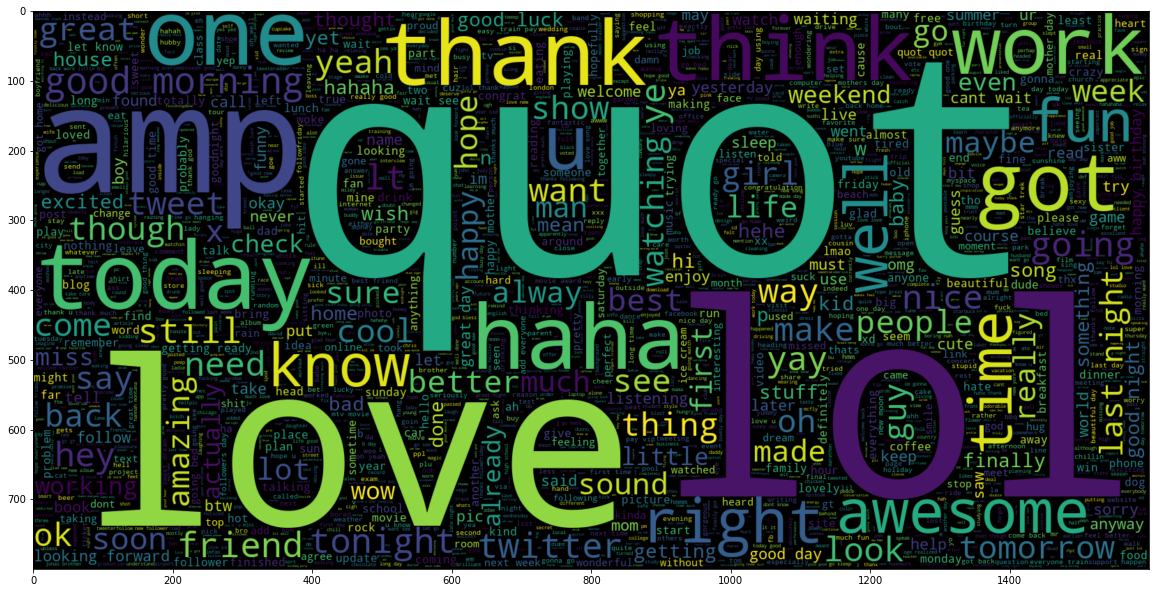

In [21]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [22]:
TRAIN_SIZE = 0.8

In [23]:
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [24]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [25]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


In [26]:
test_data.head(10)

,sentiment,text
709290,Negative,feelin lately reason
654075,Negative,ju clare elly zoe leave marbella
728623,Negative,wish couldve seen miley nick sing 2night
697650,Negative,work today 1 hour 6 go
1244425,Positive,started catch house viewing kind odd watched b...
471810,Negative,yeah already applied couple one really want go...
928654,Positive,watching spanish television mom
81604,Negative,2 days go still know even spend 2k mom said sa...
395779,Negative,heart breaking news mustang travelled accross ...
874650,Positive,time disconnect fantastic dinner waiting great...


In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [28]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [29]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [30]:
labels = train_data.sentiment.unique().tolist()

In [31]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [28]:
#!wget --no-check-certificate -P ./wordEmbedding/ http://nlp.stanford.edu/data/glove.6B.zip

In [29]:
#!unzip ./wordEmbedding/glove.twitter.27B.zip

In [32]:
GLOVE_EMB = '../wordEmbedding/glove.twitter.27B/glove.twitter.27B.200d.txt'
EMBEDDING_DIM = 200
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = './output/best_model.hdf5'

In [33]:
embeddings_index = {}

f = open(GLOVE_EMB, encoding="utf8")
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [34]:
print('Found %s word vectors.' %len(embeddings_index))

Found 1193514 word vectors.


In [35]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [36]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [37]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [38]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)
temp_model_dir = pathlib.Path(temp_dir)
temp_model_dir.mkdir(exist_ok = True, parents = True)
er_path = pathlib.Path(temp_model_dir, "savedModel.pkl")

In [40]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=15,validation_data=(x_test, y_test),use_multiprocessing=False, callbacks=[ReduceLROnPlateau])


Epoch 1/15
1250/1250 [==============================] - 143s 114ms/step - loss: 0.4952 - accuracy: 0.7560 - val_loss: 0.4613 - val_accuracy: 0.7795
Epoch 2/15
1250/1250 [==============================] - 152s 122ms/step - loss: 0.4703 - accuracy: 0.7733 - val_loss: 0.4532 - val_accuracy: 0.7849
Epoch 3/15
1250/1250 [==============================] - 168s 135ms/step - loss: 0.4614 - accuracy: 0.7792 - val_loss: 0.4481 - val_accuracy: 0.7872
Epoch 4/15
1250/1250 [==============================] - 179s 143ms/step - loss: 0.4560 - accuracy: 0.7824 - val_loss: 0.4467 - val_accuracy: 0.7880
Epoch 5/15
1250/1250 [==============================] - 176s 141ms/step - loss: 0.4523 - accuracy: 0.7846 - val_loss: 0.4429 - val_accuracy: 0.7904
Epoch 6/15
1250/1250 [==============================] - 176s 141ms/step - loss: 0.4495 - accuracy: 0.7865 - val_loss: 0.4424 - val_accuracy: 0.7913
Epoch 7/15
1250/1250 [==============================] - 176s 140ms/step - loss: 0.4467 - accuracy: 0.7882 - val_

In [41]:
model.save("my_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model\assets


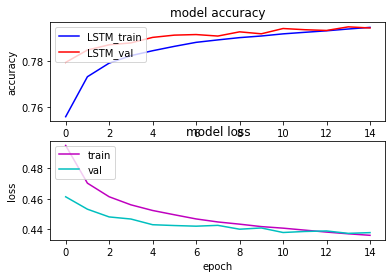

In [42]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [88]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"

In [ ]:
scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

In [56]:
mytest = ["This is great", "This is bad"]
mytest_padding = pad_sequences(tokenizer.texts_to_sequences(mytest),
                       maxlen = MAX_SEQUENCE_LENGTH)

In [57]:
mytest_padding

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 39],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 49]])

In [58]:
myTest_scores = model.predict(mytest_padding, verbose=1, batch_size=10000)

1/1 [==============================] - 0s 2ms/step


In [61]:
myTest_pred_1d = [decode_sentiment(score) for score in myTest_scores]

In [62]:
myTest_pred_1d

['Positive', 'Negative']

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [ ]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

In [ ]:
## Twitter feed

In [11]:
import keras

In [12]:
model = keras.models.load_model("my_model")

In [13]:
pip install tweepy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\bahug\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [14]:
import tweepy

In [29]:
consumer_key = "2kSfj8TQAPWbKH7EOCM2sh1lw"
consumer_secret = "4DgWq1YpYGj4fBssiF6CVdY8qKoH0C0CJKUBOagek1oM7P6UoI"
access_token = "735672620700442624-lYgFDBzuZo6LpilkVRbrFkRfdMeTmYn"
access_token_secret = "O26Q6EH62aW5LTuhR4dARjWzKLwY49Lmc9S4GNXRcCGBS"

In [30]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Setting your access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth) 

In [17]:
name = "uber"
# Number of tweets to pull
tweetCount = 20
results = api.user_timeline(id=name, count=tweetCount, include_rts=False)
for tweet in results:
   # printing the text stored inside the tweet object
   print (tweet.text)

@SresthaDasChou1 Hey Srestha, while our safety guidelines don't have it as a compulsion, we strongly recommend to,… https://t.co/3aLyfWmw56
@BISWAJITPAUL21 Hey there, it looks like the account registered with 9830087007 might have accidentally created mul… https://t.co/zmMpwVbOyl
@Braeboicarti We are sorry to hear about this experience and would like to follow up with you for more information.… https://t.co/lchNbPoFgR
Meta Uber Pool https://t.co/JZvBx3KRTi
@StevieNorrisxo Hi Stevie, we are happy to help. Please follow our support page: https://t.co/V1lNEfvI9k so our Ube… https://t.co/xLrBwi6elq
@sheni_coker Just like drivers, saying thank you takes you places. ❤️
@momcrotch Thanks for riding safely. ❤️
@lexyluvsnia We are sorry to hear about this experience and would like to follow up with you for more information.… https://t.co/47oPNbSq3k
@Swapnil6098 Hey Swapnil, this is certainly not the experience we expect you to have on the platform. We've made a… https://t.co/IqdkfeMBGs
@JohnMil

In [18]:
results

[Status(_api=<tweepy.api.API object at 0x00000127111E78B0>, _json={'created_at': 'Sun Dec 06 12:35:25 +0000 2020', 'id': 1335563493861416960, 'id_str': '1335563493861416960', 'text': "@SresthaDasChou1 Hey Srestha, while our safety guidelines don't have it as a compulsion, we strongly recommend to,… https://t.co/3aLyfWmw56", 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'SresthaDasChou1', 'name': 'Srestha Das Choudhury', 'id': 1045026781479063552, 'id_str': '1045026781479063552', 'indices': [0, 16]}], 'urls': [{'url': 'https://t.co/3aLyfWmw56', 'expanded_url': 'https://twitter.com/i/web/status/1335563493861416960', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [116, 139]}]}, 'source': '<a href="https://www.sprinklr.com" rel="nofollow">Sprinklr</a>', 'in_reply_to_status_id': 1335560797230010368, 'in_reply_to_status_id_str': '1335560797230010368', 'in_reply_to_user_id': 1045026781479063552, 'in_reply_to_user_id_str': '104502678

In [28]:
inputArray = []
search_words = "#uber"
date_since = "2020-01-01"
for tweet in results:
    tweet_id = tweet.id_str
    #print(tweet_id)
    for perTweet in tweepy.Cursor(api.search,q=search_words+" -filter:retweets",lang="en",since=date_since, result_type='recent', timeout=999999, include_rts=False).items(10):
        if hasattr(perTweet, 'in_reply_to_status_id_str'):
            #print("yes - " + str(perTweet))
            print(perTweet.in_reply_to_status_id_str)
            print(tweet_id)
            if (perTweet.in_reply_to_status_id_str==tweet_id):
                print("equals - "+tweet_id)
                inputArray.append(perTweet)
    break
input_df = pd.DataFrame(inputArray,columns=['text'])

1331041802271375360
1335563493861416960
None
1335563493861416960
None
1335563493861416960
None
1335563493861416960
None
1335563493861416960
None
1335563493861416960
None
1335563493861416960
1335618433807872002
1335563493861416960
None
1335563493861416960
None
1335563493861416960


In [33]:
inputArray = []
search_words = "#uber"
date_since = "2020-01-01"
for tweet in tweepy.Cursor(api.search,q=search_words+" -filter:retweets",lang="en",since=date_since, result_type='recent', timeout=999999, include_rts=False).items(10):
    inputArray.append(tweet.text)
input_df = pd.DataFrame(inputArray,columns=['text'])

In [34]:
input_df

,text
0,@TeachGrant @OmariAkilNewton @JennMacA @Uber D...
1,Food delivery deaths: NSW transport minister c...
2,Haseeb el ta3leem w asht8al f uber eats @UberE...
3,How Loss Aversion Bias helped Uber beat the ta...
4,@UberEats @ubereats_uk don’t ever order from h...
5,Next time when you take an #Uber or hitch a ri...
6,#Uber seek Localization Program Managers in #B...
7,@Mochievous #Lyft &amp; #Uber use @checkr for ...
8,$UBER Some more hints about this setting.\n\nT...
9,Are you a Blockbuster or a #Netflix? Business ...


In [37]:
def preprocessInput(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [38]:
input_df.text = input_df.text.apply(lambda x: preprocessInput(x))

In [39]:
input_df

,text
0,omariakilnewton jennmaca uber data protection ...
1,food delivery deaths nsw transport minister cr...
2,haseeb el ta3leem w asht8al f uber eats uberea...
3,loss aversion bias helped uber beat taxi indus...
4,ubereats uk ever order wrong order turned clai...
5,next time take uber hitch ride office remember...
6,uber seek localization program managers buenos...
7,lyft amp uber use checkr background checks nei...
8,uber hints setting verticality actually someth...
9,blockbuster netflix business models fire tech ...


In [40]:
inputList = np.array(input_df).flatten()

In [41]:
inputList

array(['omariakilnewton jennmaca uber data protection serious problem uber uncle similar',
       'food delivery deaths nsw transport minister criticised victim blaming minicab uber addisonlee taxi gr',
       'haseeb el ta3leem w asht8al f uber eats ubereats sponsor please uber',
       'loss aversion bias helped uber beat taxi industry loss aversion bias',
       'ubereats uk ever order wrong order turned claimed refund still received af',
       'next time take uber hitch ride office remember open car window closest',
       'uber seek localization program managers buenosaires argentina opaulo brazil mexicocity mexico',
       'lyft amp uber use checkr background checks neither company responsible 3rd party',
       'uber hints setting verticality actually something inverted shs scenario must',
       'blockbuster netflix business models fire tech driven service based models massively'],
      dtype=object)

In [83]:
tokenizer
with open('tokenizer.pickle', 'rb') as handle:
     tokenizer = pickle.load(handle)

In [84]:

input_df_padding = pad_sequences(tokenizer.texts_to_sequences(inputList),
                       maxlen = MAX_SEQUENCE_LENGTH)

In [85]:
input_df_padding

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  3351,  2098,  6483,   964,   496,
         3351,  1807,  2626],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   266,  2790, 11853,  7722,  5831,  9988,  7476,  9559,
         3351,  4456,  7677],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  2017,   180,   757,  3351,  4986,
         7898,    92,  3351],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,  1480, 34757, 13730,  1901,  3351,   800,  4456,  5002,
         1480, 34757, 13730],
       [    0,     0,     0,

In [86]:
input_df_scores = model.predict(input_df_padding, verbose=1, batch_size=10000)

1/1 [==============================] - 0s 2ms/step


In [89]:
input_df_pred_1d = [decode_sentiment(score) for score in input_df_scores]

In [90]:
input_df_pred_1d

['Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative']